# Balanced Generator Demo

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
from tqdm import tqdm
from skimage import measure
from shapely.geometry import Polygon

### Utility Functions

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes, class_dict,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # convert class_id to class_name using the class_dict
    cover_names = []
    for cover_class in classes:
        cover_names.append(class_dict[cover_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=cover_names, yticklabels=cover_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

"""
TO Run: 

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

plt.show()
"""


'\nTO Run: \n\nnp.set_printoptions(precision=2)\n\n# Plot non-normalized confusion matrix\nplot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),\n                      class_dict=class_names)\n\n# Plot normalized confusion matrix\nplot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),\n                      class_dict=class_names,\n                      normalize=True)\n\nplt.show()\n'

### Open up Datasets

In [3]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']

landsat_datasets = []
for fp in image_paths:
    landsat_datasets.append(rasterio.open(fp))

In [4]:
def merge_classes(label_image):
    # merge some of the labels
    # medium intensity and high intensity
    label_image[label_image == 3] = 2
    # open space developed and cultivated land
    label_image[label_image == 5] = 6
    # pasture/hay and grassland
    label_image[label_image == 7] = 8
    # deciduous forest and mixed forest
    label_image[label_image == 9] = 11
    # estuarine forest wetland to palustrine forested wetland
    label_image[label_image == 16] = 13
    
    return(label_image)

In [6]:
label_image = label_dataset.read()
label_image[label_image == 255] = 1
    
class_count = len(np.unique(label_image))
label_image = merge_classes(label_image)

def tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]

    #print("num unique = " + str(len(np.unique(label_image))))

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, 7)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            r,c = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            # window is the format Window(col_off, row_off, width, height)
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (band_count, tile_width, tile_height):
                #print('wrong shape')
                #print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:
                tile = adjust_band(tile[0:7])
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)
                #print(reshaped_tile.shape)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[0, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile[:,:,:]
                    b += 1
        yield (image_batch, label_batch)


In [7]:
import rasterio.features
import rasterio.warp
import rasterio.mask

def gen_balanced_pixel_locations(image_datasets, train_count):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    label_proj = Proj(label_dataset.crs)
    
    train_pixels = []
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    for index, image_dataset in enumerate(tqdm(image_datasets)):

        # how many points from each class
        points_per_class = train_count_per_dataset // 23
        
        # get landsat boundaries in this image
        # create approx dataset mask in geographic coords
        # this fcn maps pixel locations in (row, col) coordinates to (x, y) spatial positions
        raster_points = image_dataset.transform * (0, 0), image_dataset.transform * (image_dataset.width, 0), image_dataset.transform * (image_dataset.width, image_dataset.height), image_dataset.transform * (0, image_dataset.height)
        
        l8_proj = Proj(image_dataset.crs)
        new_raster_points = []
        # convert the raster bounds from landsat into label crs
        for x,y in raster_points:
            new_raster_points.append(transform(l8_proj,label_proj,x,y))
            
        # turn this into a polygon
        raster_poly = Polygon(new_raster_points)

        # mask the label dataset to landsat
        masked_label_image, masked_label_transform = rasterio.mask.mask(label_dataset, [raster_poly.__geo_interface__], crop=False)
        masked_label_image = merge_classes(masked_label_image)
        print('Dataset Index is: ', index)
        print('raster points and geojson')
        print(new_raster_points)
        print(raster_poly.__geo_interface__)

        all_points_per_image = []
        # loop for each class
        for cls in range(23):
            print(cls)  
            # mask the label subset image to each class
            class_mask_image = (masked_label_image==cls).astype(int)
            
            # pull out the indicies where the mask is true
            rows,cols = np.where(class_mask_image[0] == 1)
            all_locations = list(zip(rows,cols))
            print('total class count', len(all_locations))

            # shuffle all locations
            random.shuffle(all_locations)
            
            # now convert to landsat image crs
            # TODO need to time this to see if it is slow, can probably optimize
            l8_points = []
            # TODO Will probably need to catch this for classes smaller than the ideal points per class
            for r,c in all_locations[:points_per_class]:
                # convert label row and col into label geographic space
                x,y = label_dataset.xy(r,c)
                # go from label projection into landsat projection
                x,y = transform(label_proj, l8_proj,x,y)
                # convert from landsat geographic space into row col
                r,c = image_dataset.index(x,y)
                l8_points.append((r,c))
                                 
            all_points_per_image += l8_points
            print('point #', len(l8_points))
            print('total point #', len(all_points_per_image))

        dataset_index_list = [index] * len(all_points_per_image)

        dataset_pixels = list(zip(all_points_per_image, dataset_index_list))
        
        train_pixels += dataset_pixels
            
    random.shuffle(train_pixels)
    return (train_pixels)

### Test the Generator

In [13]:
train_pixels = gen_balanced_pixel_locations(image_datasets=landsat_datasets, train_count=50000)

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset Index is:  0
raster points and geojson
[(100454.97460920096, 3939519.0575776207), (248302.54640008672, 3907013.9128797767), (215471.63888613222, 3761729.9570575366), (67716.65578825137, 3794070.939442249)]
{'coordinates': (((100454.97460920096, 3939519.0575776207), (248302.54640008672, 3907013.9128797767), (215471.63888613222, 3761729.9570575366), (67716.65578825137, 3794070.939442249), (100454.97460920096, 3939519.0575776207)),), 'type': 'Polygon'}
0
total class count 2658939
point # 724
total point # 724
1
total class count 0
point # 0
total point # 724
2
total class count 178795
point # 724
total point # 1448
3
total class count 0
point # 0
total point # 1448
4
total class count 647267
point # 724
total point # 2172
5
total class count 0
point # 0
total point # 2172
6
total class count 6257546
point # 724
total point # 2896
7
total class count 0
point # 0
total point # 2896
8
total class count 1294651
point # 724
total point # 3620
9
total class count 0
point # 0
total point

 33%|███▎      | 1/3 [01:40<03:21, 100.90s/it]

total class count 204
point # 204
total point # 9630
Dataset Index is:  1
raster points and geojson
[(281311.2313435933, 4052087.6429721154), (429047.5196220781, 4019509.6064301943), (395961.1108715221, 3874500.8075037072), (248302.54640008672, 3907013.9128797767)]
{'coordinates': (((281311.2313435933, 4052087.6429721154), (429047.5196220781, 4019509.6064301943), (395961.1108715221, 3874500.8075037072), (248302.54640008672, 3907013.9128797767), (281311.2313435933, 4052087.6429721154)),), 'type': 'Polygon'}
0
total class count 9744
point # 724
total point # 724
1
total class count 0
point # 0
total point # 724
2
total class count 87836
point # 724
total point # 1448
3
total class count 0
point # 0
total point # 1448
4
total class count 299439
point # 724
total point # 2172
5
total class count 0
point # 0
total point # 2172
6
total class count 6584971
point # 724
total point # 2896
7
total class count 0
point # 0
total point # 2896
8
total class count 1235854
point # 724
total point # 36

 67%|██████▋   | 2/3 [03:21<01:40, 100.84s/it]

total class count 243
point # 243
total point # 11827
Dataset Index is:  2
raster points and geojson
[(100454.97460920096, 3939519.0575776207), (248302.54640008672, 3907013.9128797767), (215471.63888613222, 3761729.9570575366), (67716.65578825137, 3794070.939442249)]
{'coordinates': (((100454.97460920096, 3939519.0575776207), (248302.54640008672, 3907013.9128797767), (215471.63888613222, 3761729.9570575366), (67716.65578825137, 3794070.939442249), (100454.97460920096, 3939519.0575776207)),), 'type': 'Polygon'}
0
total class count 2658939
point # 724
total point # 724
1
total class count 0
point # 0
total point # 724
2
total class count 178795
point # 724
total point # 1448
3
total class count 0
point # 0
total point # 1448
4
total class count 647267
point # 724
total point # 2172
5
total class count 0
point # 0
total point # 2172
6
total class count 6257546
point # 724
total point # 2896
7
total class count 0
point # 0
total point # 2896
8
total class count 1294651
point # 724
total po

100%|██████████| 3/3 [05:02<00:00, 100.73s/it]

total class count 204
point # 204
total point # 9630


In [14]:
all_labels = []
label_locations = []
for pixel in train_pixels:
    # row, col location in landsat
    r,c = pixel[0]
    ds_index = pixel[1]
    l8_proj = Proj(landsat_datasets[ds_index].crs)
    label_proj = Proj(label_dataset.crs)
    
    # geographic location in landsat
    x,y = landsat_datasets[ds_index].xy(r,c)
    # go from label projection into landsat projection
    x,y = transform(l8_proj, label_proj ,x,y)
    # get row and col location in label
    r,c = label_dataset.index(x,y)
    
    label_locations.append([r,c])
    
    # format (bands, height, width)
    all_labels.append(label_image[0,r,c])

In [15]:
label_locations = np.array(label_locations)

In [16]:
unique, counts = np.unique(np.array(train_pixels)[:, 1], return_counts=True)
dict(zip(unique, counts))

{0: 9630, 1: 11827, 2: 9630}

In [17]:
unique, counts = np.unique(np.array(all_labels), return_counts=True)
dict(zip(unique, counts))

{0: 2170,
 2: 2127,
 4: 2130,
 6: 2279,
 8: 2169,
 10: 2213,
 11: 2121,
 12: 2206,
 13: 2255,
 14: 2172,
 15: 2148,
 17: 703,
 18: 761,
 19: 718,
 20: 2132,
 21: 2158,
 22: 625}

Check the geographic distrobution

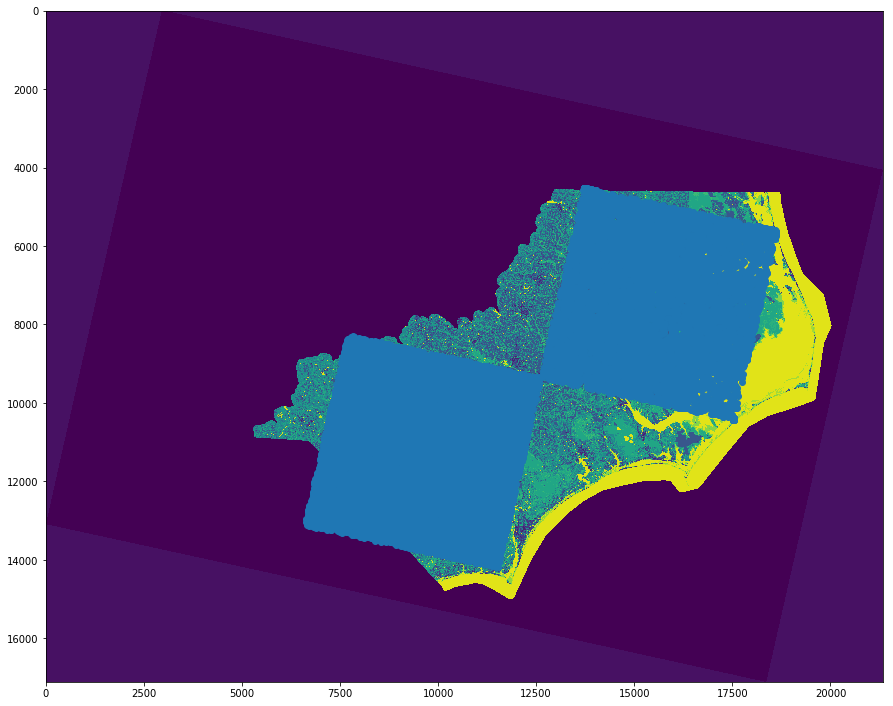

In [18]:
fig, ax = plt.subplots(figsize=[15,15])
ax.imshow(label_image[0,:,:])

plt.scatter(label_locations[:, 1], label_locations[:, 0])

## Test it with a CNN

In [19]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use
# Patrick "0"
# Feroze  "1"
# Yousuf  "2"
# Diego   "3"
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [20]:
# Do other imports now...
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [21]:
batch_size = 25
tile_side = 21
input_shape = (tile_side, tile_side, 7)
num_classes = 23
weight_decay = 0.01

In [22]:
model = Sequential()

model.add(Conv2D(tile_side, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(42, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(84, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 19, 19, 21)        1344      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 42)        7980      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 42)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 42)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 84)          31836     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 84)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 84)          0         
__________

In [24]:
train_to_val_ratio = 0.8
train_pixels_subset = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_pixels_subset = train_pixels[int(len(train_pixels)*train_to_val_ratio):]

In [26]:
len(val_pixels_subset)

6218

In [28]:
sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#sgd = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)
history = model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, train_pixels_subset, batch_size), 
                    steps_per_epoch=len(train_pixels_subset) // batch_size, epochs=80, verbose=1,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, val_pixels_subset, batch_size),
                    validation_steps=len(val_pixels_subset) // batch_size,
                   shuffle=True)

Epoch 1/80


/usr/local/lib/python3.5/dist-packages/rasterio/plot.py:319: RuntimeWarning: overflow encountered in short_scalars
  band_normed = (band - imin) / (imax - imin)


994/994 [==============================] - 36s 36ms/step - loss: 2.5641 - acc: 0.1280 - val_loss: 2.4032 - val_acc: 0.1629
Epoch 2/80
994/994 [==============================] - 33s 33ms/step - loss: 2.3425 - acc: 0.1830 - val_loss: 2.2623 - val_acc: 0.2177
Epoch 3/80
994/994 [==============================] - 32s 32ms/step - loss: 2.2498 - acc: 0.2092 - val_loss: 2.1823 - val_acc: 0.2395
Epoch 4/80
994/994 [==============================] - 32s 32ms/step - loss: 2.2120 - acc: 0.2185 - val_loss: 2.1688 - val_acc: 0.2418
Epoch 5/80
994/994 [==============================] - 32s 33ms/step - loss: 2.1833 - acc: 0.2272 - val_loss: 2.1395 - val_acc: 0.2505
Epoch 6/80
994/994 [==============================] - 33s 33ms/step - loss: 2.1542 - acc: 0.2336 - val_loss: 2.1173 - val_acc: 0.2558
Epoch 7/80
994/994 [==============================] - 32s 33ms/step - loss: 2.1251 - acc: 0.2463 - val_loss: 2.0813 - val_acc: 0.2539
Epoch 8/80
994/994 [==============================] - 32s 32ms/step - los

Epoch 62/80
994/994 [==============================] - 33s 33ms/step - loss: 1.7016 - acc: 0.3852 - val_loss: 1.7660 - val_acc: 0.3700
Epoch 63/80
994/994 [==============================] - 33s 33ms/step - loss: 1.6925 - acc: 0.3892 - val_loss: 1.7588 - val_acc: 0.3750
Epoch 64/80
994/994 [==============================] - 33s 33ms/step - loss: 1.6932 - acc: 0.3867 - val_loss: 1.7732 - val_acc: 0.3648
Epoch 65/80
994/994 [==============================] - 32s 33ms/step - loss: 1.6849 - acc: 0.3936 - val_loss: 1.8006 - val_acc: 0.3429
Epoch 66/80
994/994 [==============================] - 32s 33ms/step - loss: 1.6842 - acc: 0.3926 - val_loss: 1.7614 - val_acc: 0.3703
Epoch 67/80
994/994 [==============================] - 33s 33ms/step - loss: 1.6775 - acc: 0.3952 - val_loss: 1.7574 - val_acc: 0.3748
Epoch 68/80
994/994 [==============================] - 33s 33ms/step - loss: 1.6746 - acc: 0.3913 - val_loss: 1.7511 - val_acc: 0.3769
Epoch 69/80
994/994 [==============================] - 

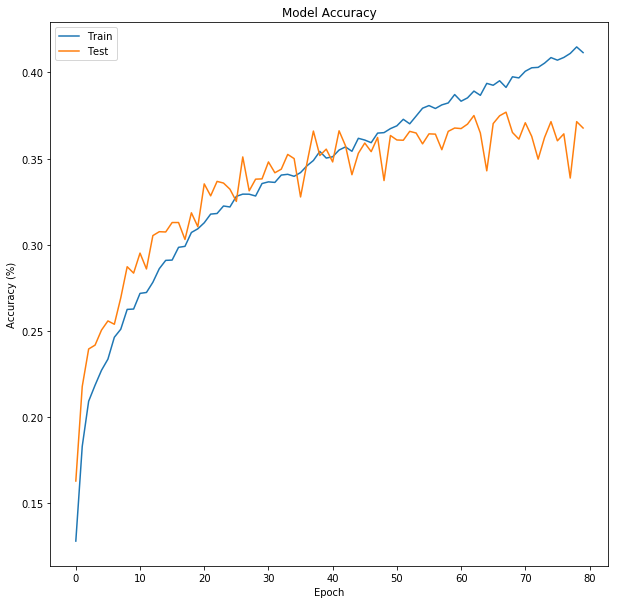

In [29]:
plt.figure(figsize=(10,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


In [30]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

248/248 [==============================] - 6s 25ms/step


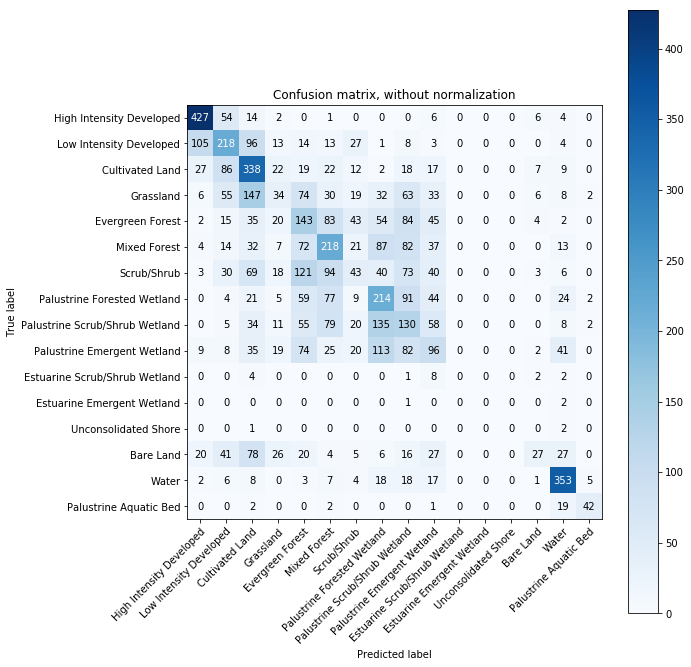

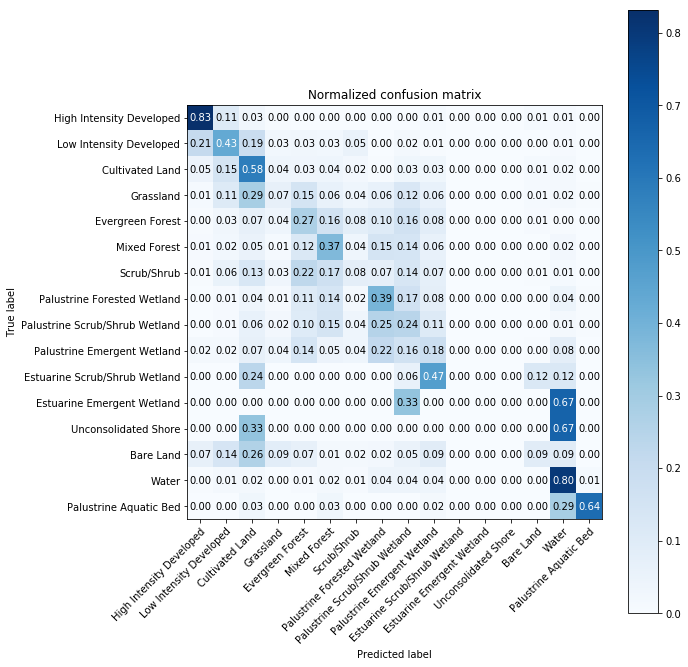

In [41]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, val_pixels_subset, batch_size), 
                        steps=len(val_pixels_subset) // batch_size,
                         verbose=1)
eval_generator = tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, val_pixels_subset, batch_size=1)
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [35]:
model.evaluate_generator(generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, val_pixels_subset, batch_size), 
                        steps=len(val_pixels_subset) // batch_size,
                         verbose=1)

248/248 [==============================] - 6s 25ms/step


[1.763126519418532, 0.3682258059120467]